| 1flip | 3flip | 5flip | bitFlip |
|-------|-------|-------|---------|
| proba | proba | proba | proba   |
| utilité | utilité | utilité | utilité |
| nb d'utilisation | nb d'utilisation | nb d'utilisation | nb d'utilisation |

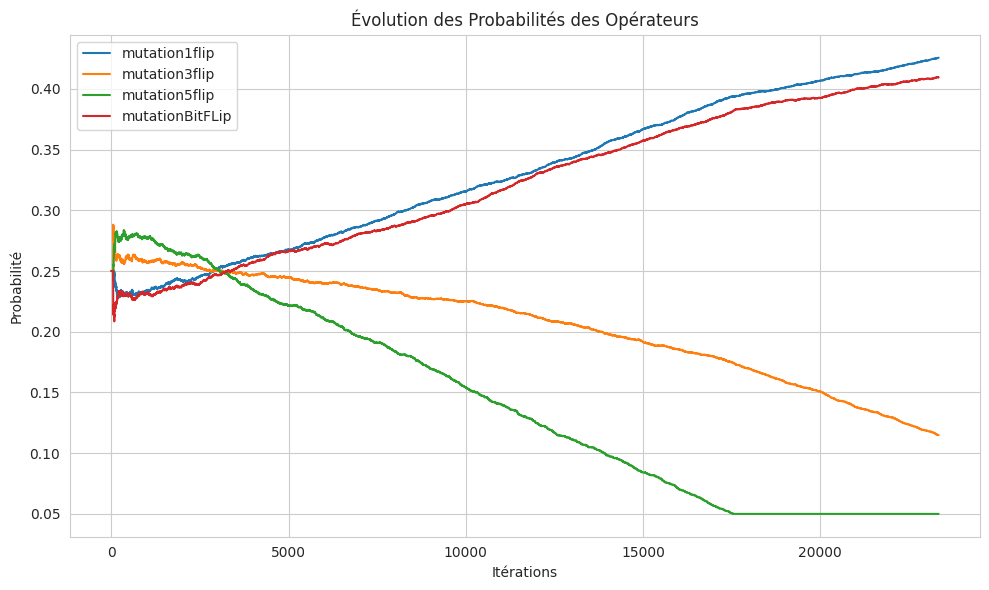

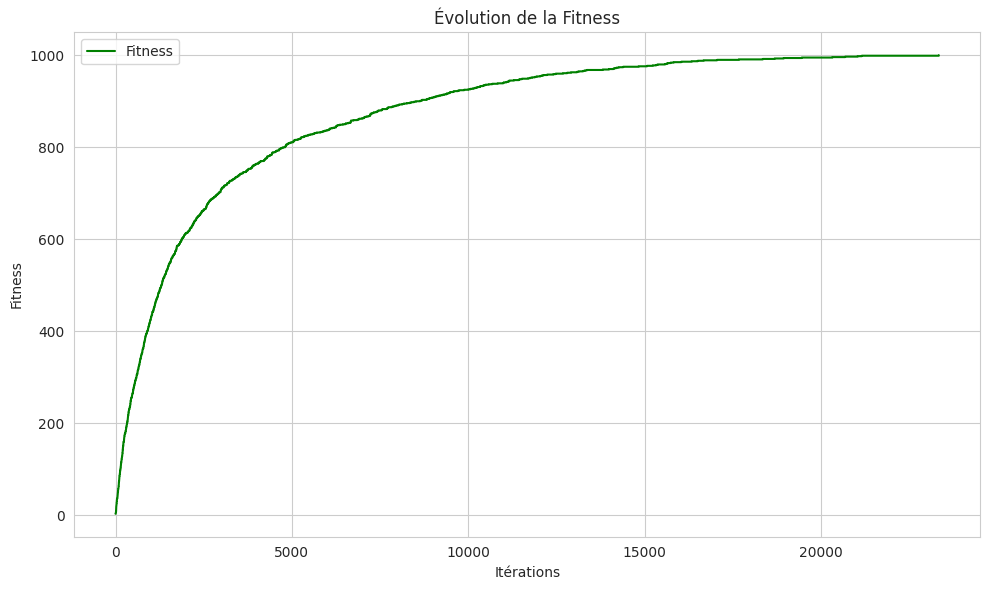

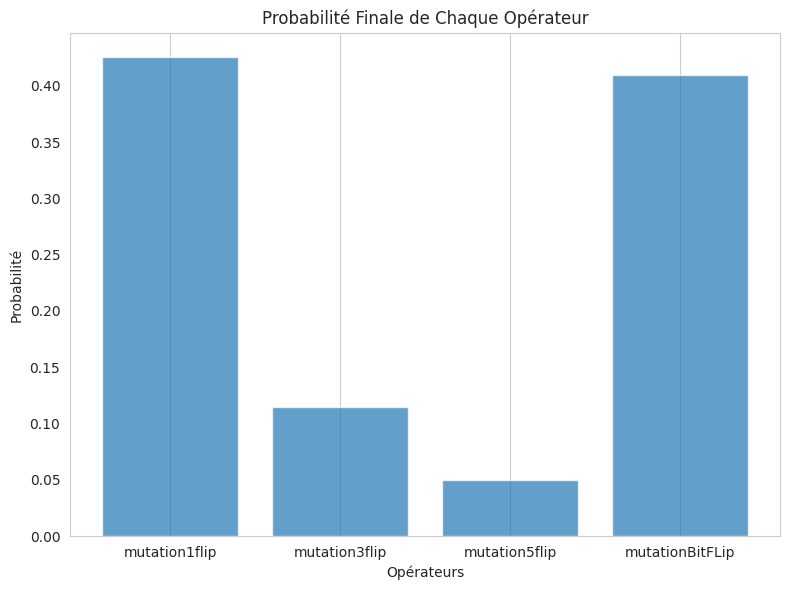

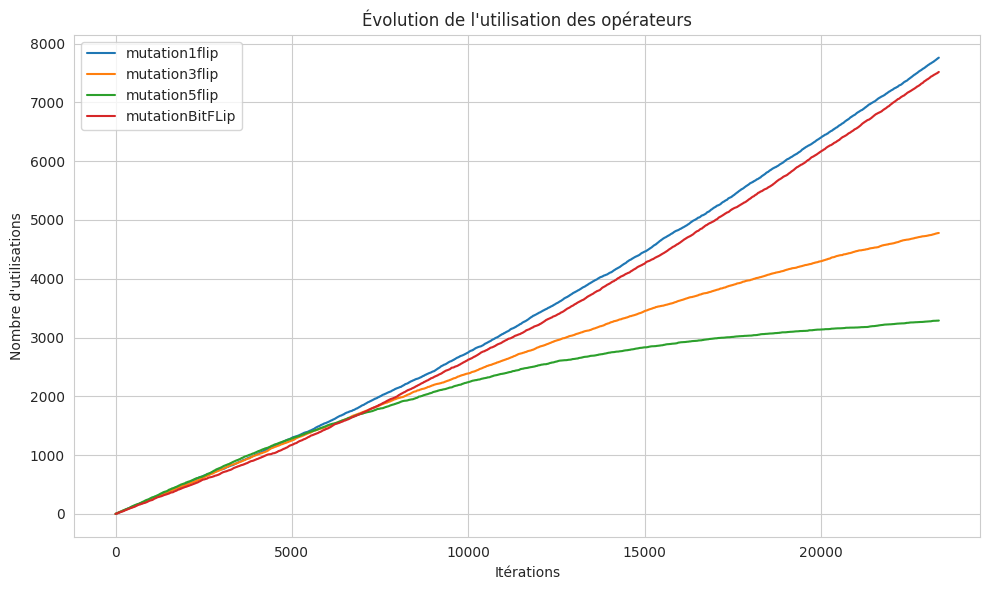

Somme des probabilités (finale): 1.0


In [1]:
import random
import matplotlib.pyplot as plt
from fitness import Fitness
from randomOneMax import RandomOneMax

# === Paramètres globaux ===
TAILLE_VECTEUR = 1000
TAILLE_POPULATION = 20
MAX_ITER = 30000
P_MIN = 0.05
ALPHA = 0.01
N = 4

# === Matrice des opérateurs (initialisation) ===
operator_matrix = [
    {"operator": "mutation1flip",   "proba": 1.0/N, "utilite": 0.0, "nb_utilisation": 0},
    {"operator": "mutation3flip",   "proba": 1.0/N, "utilite": 0.0, "nb_utilisation": 0},
    {"operator": "mutation5flip",   "proba": 1.0/N, "utilite": 0.0, "nb_utilisation": 0},
    {"operator": "mutationBitFLip", "proba": 1.0/N, "utilite": 0.0, "nb_utilisation": 0}
]

def replace_pire(population, new_individual):
    # Remplacer le pire individu dans la population
    pire_individu = min(population, key=lambda x: Fitness(x).getFitness())
    population.remove(pire_individu)
    population.append(new_individual)

def initialisationPopulation(npop):
    #return [[random.randint(0, 1) for _ in range(TAILLE_VECTEUR)] for _ in range(npop)]
    return [[0] * TAILLE_VECTEUR] * npop

def selection2Best(population):
    return sorted(population, key=lambda x: Fitness(x).getFitness(), reverse=True)[:2]

def mutation1flip(individual):
    new_individual = individual.copy()
    mutationPoint = random.randint(0, TAILLE_VECTEUR - 1)
    new_individual[mutationPoint] = 1 - new_individual[mutationPoint]
    return new_individual

def mutation3flip(individual):
    new_individual = individual.copy()
    indices = random.sample(range(TAILLE_VECTEUR), 3)
    for idx in indices:
        new_individual[idx] = 1 - new_individual[idx]
    return new_individual

def mutation5flip(individual):
    new_individual = individual.copy()
    indices = random.sample(range(TAILLE_VECTEUR), 5)
    for idx in indices:
        new_individual[idx] = 1 - new_individual[idx]
    return new_individual

def mutationBitFLip(individual):
    new_individual = individual.copy()
    for i in range(TAILLE_VECTEUR):
        if random.random() < (1 / TAILLE_VECTEUR):
            new_individual[i] = 1 - new_individual[i]
    return new_individual

def selectionTournament(population, tournament_size=3):
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda x: Fitness(x).getFitness(), reverse=True)
    return tournament[0]

def get_mean_fitness_of_population(population):
    total = 0.0
    for indiv in population:
        total += Fitness(indiv).getFitness()
    return total / len(population)

def mutate_no_update(operator, population):
    """
    Fait la même chose que 'mutate' sauf qu'on ne met PAS à jour
    l'utilité ni la matrice de probabilités.
    """
    # 1) Sélection tournoi
    fitness_before = get_mean_fitness_of_population(population)
    individual_selected = selectionTournament(population)
    # 2) Mutation
    new_individual = operator(individual_selected)
    # 3) Remplacement
    replace_pire(population, new_individual)
    # 4) Pas de mise à jour des probas
    # Reward
    fitness_after = get_mean_fitness_of_population(population)
    immediate_reward = fitness_after - fitness_before

    for row in operator_matrix:
        if row["operator"] == operator.__name__:
            # Incrémenter d'abord le nombre d'utilisations
            row["nb_utilisation"] += 1
            
            # Mise à jour de l'utilité par moyenne incrémentale
            # util_new = util_old + (immediate_reward - util_old) / nb_utilisation
            old_util = row["utilite"]
            usage_count = row["nb_utilisation"]
            new_util = (old_util + (immediate_reward - old_util) / usage_count) 
            
            # On peut imposer un min à 0 si on ne veut pas d'utilité négative :
            row["utilite"] = max(0, new_util)
            
            break


def mutate(operator, population):
    global operator_matrix

    fitness_before = get_mean_fitness_of_population(population)

    # Sélection tournoi + mutation + remplacement
    individual_selected = selectionTournament(population)
    new_individual = operator(individual_selected)
    replace_pire(population, new_individual)

    # Reward
    fitness_after = get_mean_fitness_of_population(population)
    immediate_reward = fitness_after - fitness_before

    # Mise à jour opérateur
    for row in operator_matrix:
        if row["operator"] == operator.__name__:
            # Incrémenter d'abord le nombre d'utilisations
            row["nb_utilisation"] += 1
            
            # Mise à jour de l'utilité par moyenne incrémentale
            # util_new = util_old + (immediate_reward - util_old) / nb_utilisation
            old_util = row["utilite"]
            usage_count = row["nb_utilisation"]
            new_util = (old_util + (immediate_reward - old_util) / usage_count) 
            
            # On peut imposer un min à 0 si on ne veut pas d'utilité négative :
            row["utilite"] = max(0, new_util)
            
            break


    # Recalcul des probas
    sum_util = sum(max(0.0, r["utilite"]) for r in operator_matrix)
    if sum_util > 0:
        for r in operator_matrix:
            u = max(0.0, r["utilite"])
            r["proba"] = P_MIN + (1 - N * P_MIN) * (u / sum_util)
    else:
        for r in operator_matrix:
            r["proba"] = 1.0 / N

    # Normalisation
    total_prob = sum(r["proba"] for r in operator_matrix)
    if total_prob > 0:
        for r in operator_matrix:
            r["proba"] /= total_prob
    else:
        for r in operator_matrix:
            r["proba"] = 1.0 / N

def evolution_with_mutation_test():
    global operator_matrix

    # Réinitialisation de la matrice des opérateurs
    for r in operator_matrix:
        r["proba"] = 1.0 / N
        r["utilite"] = 0.0
        r["nb_utilisation"] = 0

    population = initialisationPopulation(TAILLE_POPULATION)

    prob_history = []
    fitness_history = []
    usage_history = [] 
    nb_eval_history = []
    

    # On stocke les valeurs initiales
    prob_history.append([row["proba"] for row in operator_matrix])
    usage_history.append([row["nb_utilisation"] for row in operator_matrix])

    i = 0
    WARMUP = 50
    nb_eval = 0
    while i < MAX_ITER and Fitness(selection2Best(population)[0]).getFitness() < TAILLE_VECTEUR:
        # Choix de l'opérateur en fonction des probas
        operator_list = [mutation1flip, mutation3flip, mutation5flip, mutationBitFLip]
        prob_list = [row["proba"] for row in operator_matrix]
        selected_operator = random.choices(operator_list, weights=prob_list, k=1)[0]

        if i < WARMUP:
            # Phase "dans le vide" : on ne met pas à jour l'utilité ni les probas
            mutate_no_update(selected_operator, population)
        else:
            # Phase normale : on met à jour l'utilité et les probas
            mutate(selected_operator, population)

        # Stockage des probas courantes
        current_probs = [row["proba"] for row in operator_matrix]
        prob_history.append(current_probs)

        # Stockage de la fitness
        current_fitness = Fitness(selection2Best(population)[0]).getFitness()
        nb_eval += 2
        nb_eval_history.append(nb_eval)
        fitness_history.append(current_fitness)

        # Stockage de l'utilisation
        current_usage = [row["nb_utilisation"] for row in operator_matrix]
        usage_history.append(current_usage)

        i += 1
    return prob_history, fitness_history, usage_history, nb_eval_history

def plot_probabilities_evolution(prob_history, operator_matrix):
    iterations = range(len(prob_history))
    plt.figure(figsize=(10, 6))

    for idx, row in enumerate(operator_matrix):
        y_values = [prob_history[t][idx] for t in iterations]
        plt.plot(iterations, y_values, label=row["operator"])

    plt.xlabel('Itérations')
    plt.ylabel('Probabilité')
    plt.title('Évolution des Probabilités des Opérateurs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_fitness_evolution(fitness_history):
    iterations = range(len(fitness_history))
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, fitness_history, label='Fitness', color='green')
    plt.xlabel('Itérations')
    plt.ylabel('Fitness')
    plt.title('Évolution de la Fitness')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_histogram(matrix):
    operators = [row["operator"] for row in matrix]
    probabilities = [row["proba"] for row in matrix]

    plt.figure(figsize=(8, 6))
    plt.bar(operators, probabilities, color='tab:blue', alpha=0.7)
    plt.xlabel('Opérateurs')
    plt.ylabel('Probabilité')
    plt.title('Probabilité Finale de Chaque Opérateur')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_usage_evolution(usage_history, operator_matrix):
    """
    Trace l'évolution du nombre d'utilisations (nb_utilisation)
    de chaque opérateur au fil des itérations.
    """
    iterations = range(len(usage_history))
    plt.figure(figsize=(10, 6))

    for idx, row in enumerate(operator_matrix):
        y_values = [usage_history[t][idx] for t in iterations]
        plt.plot(iterations, y_values, label=row["operator"])

    plt.xlabel('Itérations')
    plt.ylabel("Nombre d'utilisations")
    plt.title("Évolution de l'utilisation des opérateurs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Lancement ===
if __name__ == "__main__":
    prob_history, fitness_history, usage_history, _ = evolution_with_mutation_test()
    
    # 1) Courbe d'évolution des probas
    plot_probabilities_evolution(prob_history, operator_matrix)

    # 2) Courbe d'évolution de la fitness
    plot_fitness_evolution(fitness_history)

    # 3) Histogramme final des probas
    plot_histogram(operator_matrix)

    # 4) Courbe d'évolution de l'utilisation
    plot_usage_evolution(usage_history, operator_matrix)

    # Affiche la somme finale des probabilités
    total_sum = sum(row["proba"] for row in operator_matrix)
    print("Somme des probabilités (finale):", total_sum)


In [2]:
# TODO comparer avec ucb, avec 1 flip et avec 0.25 de proba partout, faire le one max avec du Q learning
# modele en ile : ajout d'un opérateur qui transforme 2 bits en 0. un opérateur par ile (représentation avec la taille de la populatoipn ( pas la proba)

In [ ]:
N_RUNS = 10
SMOOTH_WINDOW = 5 
import numpy as np
def smooth_curve(values, window_size=5):
    """
    Applique une moyenne glissante sur la liste 'values' 
    et renvoie une liste de même dimension, lissée.
    """
    if window_size < 2:
        return values  # Pas de lissage
    smoothed = []
    for i in range(len(values)):
        # Borne inf et sup de la fenêtre
        start = max(0, i - window_size // 2)
        end = min(len(values), i + window_size // 2 + 1)
        window = values[start:end]
        smoothed.append(sum(window) / len(window))
    return smoothed
def run_multiple_evolutions(n_runs=20):
    """
    Exécute n_runs fois l'algorithme d'évolution et retourne 
    une liste des prob_history, fitness_history, usage_history et nb_eval_history de chaque run.
    """
    all_prob_histories = []
    all_fitness_histories = []
    all_usage_histories = []
    all_nb_eval_histories = []  # Nouvelle liste pour nb_eval

    for run_id in range(n_runs):
        print(f"\n=== Run {run_id+1}/{n_runs} ===")
        prob_history, fitness_history, usage_history, nb_eval_history = evolution_with_mutation_test()  # Récupération de nb_eval_history
        all_prob_histories.append(prob_history)
        all_fitness_histories.append(fitness_history)
        all_usage_histories.append(usage_history)
        all_nb_eval_histories.append(nb_eval_history)  # Ajout de nb_eval_history

    return all_prob_histories, all_fitness_histories, all_usage_histories, all_nb_eval_histories  # Retour de nb_eval_histories


def align_histories(all_prob_histories, all_fitness_histories, all_usage_histories, all_nb_eval_histories):
    """
    Aligne les runs pour qu'ils aient la même longueur d'itérations 
    en répétant la dernière valeur pour les runs plus courts.
    Retourne:
      - prob_histories_aligned : shape (n_runs, max_length, nb_opérateurs)
      - fitness_histories_aligned : shape (n_runs, max_length)
      - usage_histories_aligned : shape (n_runs, max_length, nb_opérateurs)
      - nb_eval_histories_aligned : shape (n_runs, max_length)
    """
    n_runs = len(all_prob_histories)
    # Longueur max d'itérations
    max_length = max(len(p) for p in all_prob_histories)
    # Nombre d'opérateurs
    nb_operators = len(all_prob_histories[0][0]) if max_length > 0 else 0

    # Préparer les matrices alignées
    prob_histories_aligned = np.zeros((n_runs, max_length, nb_operators))
    fitness_histories_aligned = np.zeros((n_runs, max_length))
    usage_histories_aligned = np.zeros((n_runs, max_length, nb_operators))
    nb_eval_histories_aligned = np.zeros((n_runs, max_length))  # Nouvelle matrice pour nb_eval

    for i in range(n_runs):
        p_hist = all_prob_histories[i]
        f_hist = all_fitness_histories[i]
        u_hist = all_usage_histories[i]
        e_hist = all_nb_eval_histories[i]  # Historique de nb_eval pour ce run

        for t in range(max_length):
            # Probabilités
            if t < len(p_hist):
                prob_histories_aligned[i, t, :] = p_hist[t]
            else:
                prob_histories_aligned[i, t, :] = p_hist[-1]

            # Fitness
            if t < len(f_hist):
                fitness_histories_aligned[i, t] = f_hist[t]
            else:
                fitness_histories_aligned[i, t] = f_hist[-1]

            # Usage
            if t < len(u_hist):
                usage_histories_aligned[i, t, :] = u_hist[t]
            else:
                usage_histories_aligned[i, t, :] = u_hist[-1]
            
            # nb_eval
            if t < len(e_hist):
                nb_eval_histories_aligned[i, t] = e_hist[t]
            else:
                nb_eval_histories_aligned[i, t] = e_hist[-1]

    return prob_histories_aligned, fitness_histories_aligned, usage_histories_aligned, nb_eval_histories_aligned


def plot_average_results(prob_histories_aligned, fitness_histories_aligned, operator_names, smooth_window=5):
    """
    Calcule et trace les moyennes (et éventuellement un lissage) 
    des probas et de la fitness au cours des itérations.
    """
    n_runs, max_length, nb_operators = prob_histories_aligned.shape

    # Moyenne sur l'axe des runs (axis=0)
    mean_prob_history = np.mean(prob_histories_aligned, axis=0)  # shape (max_length, nb_operators)
    mean_fitness_history = np.mean(fitness_histories_aligned, axis=0)  # shape (max_length,)

    # Lissage
    mean_prob_history_smoothed = []
    for op_idx in range(nb_operators):
        op_probs = mean_prob_history[:, op_idx].tolist()
        op_probs_smooth = smooth_curve(op_probs, window_size=smooth_window)
        mean_prob_history_smoothed.append(op_probs_smooth)

    # On transpose pour revenir à la forme (max_length, nb_operators)
    mean_prob_history_smoothed = np.array(mean_prob_history_smoothed).T

    mean_fitness_smoothed = smooth_curve(mean_fitness_history.tolist(), window_size=smooth_window)

    # --- Plot des probabilités ---
    iterations = range(max_length)
    plt.figure(figsize=(10, 6))
    for op_idx, op_name in enumerate(operator_names):
        plt.plot(iterations, mean_prob_history_smoothed[:, op_idx], label=op_name)
    plt.xlabel('Itérations')
    plt.ylabel('Probabilité (moyenne lissée)')
    plt.title('Évolution Moyenne des Probabilités (sur {} runs)'.format(n_runs))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot de la fitness ---
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, mean_fitness_smoothed, label='Fitness Moyenne Lissée', color='green')
    plt.xlabel('Itérations')
    plt.ylabel('Fitness (moyenne lissée)')
    plt.title('Évolution Moyenne de la Fitness (sur {} runs)'.format(n_runs))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_usage_results(usage_histories_aligned, operator_names, smooth_window=5):
    """
    Calcule et trace la moyenne (éventuellement lissée) 
    de l'utilisation (nb_utilisation) de chaque opérateur au cours des itérations.
    """
    # usage_histories_aligned: shape (n_runs, max_length, nb_operators)
    n_runs, max_length, nb_operators = usage_histories_aligned.shape

    # Calcul de la moyenne sur l'axe des runs
    mean_usage_history = np.mean(usage_histories_aligned, axis=0)  # (max_length, nb_operators)

    # Lissage (en reprenant la même fonction smooth_curve)
    mean_usage_history_smoothed = []
    for op_idx in range(nb_operators):
        usage_vals = mean_usage_history[:, op_idx].tolist()
        usage_smooth = smooth_curve(usage_vals, window_size=smooth_window)
        mean_usage_history_smoothed.append(usage_smooth)

    # On transpose pour revenir à la forme (max_length, nb_operators)
    mean_usage_history_smoothed = np.array(mean_usage_history_smoothed).T

    # Plot
    iterations = range(max_length)
    plt.figure(figsize=(10, 6))
    for op_idx, op_name in enumerate(operator_names):
        plt.plot(iterations, mean_usage_history_smoothed[:, op_idx], label=op_name)
    plt.xlabel('Itérations')
    plt.ylabel("Utilisation (moyenne lissée)")
    plt.title('Évolution Moyenne du Nombre d\'Utilisations (sur {} runs)'.format(n_runs))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

import os
import pandas as pd

def save_metrics_to_csv(fitness_histories_aligned, 
                        nb_eval_histories_aligned, 
                        folder="csv", 
                        filename="adaptative_wheel.csv", 
                        smooth_window=1):
    """
    Sauvegarde la fitness moyenne et nb_eval moyenne (éventuellement lissée) dans un fichier CSV.

    Parameters:
        fitness_histories_aligned (numpy.ndarray): Historique aligné de la fitness.
        nb_eval_histories_aligned (numpy.ndarray): Historique aligné de nb_eval.
        folder (str): Dossier de sauvegarde.
        filename (str): Nom du fichier CSV.
        smooth_window (int): Taille de la fenêtre de lissage (moyenne glissante).
                             Mettre 1 pour ne pas lisser.
    """

    # 1. Calculer la moyenne sur tous les runs (axe=0)
    mean_fitness = np.mean(fitness_histories_aligned, axis=0)  # shape (max_length,)
    mean_nb_eval = np.mean(nb_eval_histories_aligned, axis=0)  # shape (max_length,)

    # 2. Appliquer le lissage si nécessaire
    mean_fitness_smoothed = smooth_curve(mean_fitness.tolist(), window_size=smooth_window)
    mean_nb_eval_smoothed = smooth_curve(mean_nb_eval.tolist(), window_size=smooth_window)

    max_length = len(mean_fitness_smoothed)

    # 3. S'assurer que les deux listes ont la même longueur
    if len(mean_nb_eval_smoothed) < max_length:
        last_value = mean_nb_eval_smoothed[-1]
        mean_nb_eval_smoothed += [last_value] * (max_length - len(mean_nb_eval_smoothed))
    elif len(mean_nb_eval_smoothed) > max_length:
        mean_nb_eval_smoothed = mean_nb_eval_smoothed[:max_length]

    # 4. Construire le DataFrame
    data = {
        "generation": list(range(max_length)),
        "fitness": mean_fitness_smoothed,
        "nb_eval": mean_nb_eval_smoothed
    }
    df = pd.DataFrame(data)

    # 5. Créer le dossier s'il n'existe pas
    if not os.path.exists(folder):
        os.makedirs(folder)

    # 6. Sauvegarder en CSV
    filepath = os.path.join(folder, filename)
    df.to_csv(filepath, index=False)
    print(f"Fichier CSV sauvegardé : {filepath}")

def main():
    # 1) On suppose que operator_matrix est défini quelque part :
    operator_names = [row["operator"] for row in operator_matrix]

    # 2) Lancement de plusieurs exécutions
    all_prob_histories, all_fitness_histories, all_usage_histories, all_nb_eval_histories = run_multiple_evolutions(n_runs=N_RUNS)

    # 3) Alignement des historiques
    prob_histories_aligned, fitness_histories_aligned, usage_histories_aligned, nb_eval_histories_aligned = align_histories(
        all_prob_histories, 
        all_fitness_histories, 
        all_usage_histories,
        all_nb_eval_histories
    )

    # 4) Plot des courbes moyennes (avec lissage)
    plot_average_results(prob_histories_aligned, fitness_histories_aligned, operator_names, smooth_window=SMOOTH_WINDOW)
    
    # 5) Plot de la moyenne des usages
    plot_usage_results(usage_histories_aligned, operator_names, smooth_window=SMOOTH_WINDOW)
    
    # 6) Sauvegarde des données dans un fichier csv
    save_metrics_to_csv(fitness_histories_aligned, nb_eval_histories_aligned, 
                        folder="csv", 
                        filename="adaptative_wheel.csv", 
                        smooth_window=SMOOTH_WINDOW)


if __name__ == "__main__":
    main()



=== Run 1/10 ===
